### Content-Based Recommender: Spotify

In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
def get_profiling_report(df, path_folder: str, file_name: str='profiling_report'):
    path = Path(path_folder)
    if not os.path.isdir(path):
        os.makedirs (path)
    profile = ProfileReport(df)
    profile.to_file(path_folder / (file_name + '.html'))

path = Path("data/reports")

In [3]:
df = pd.read_csv("data/data.csv")
df.sample(2)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
146570,0.538,1974,0.592,['Bobby Bare'],0.637,218107,0.338,0,3N8w5fC2VmglVTPyvuu6pr,0.000,2,0.3540,-10.744,1,Singin' in the Kitchen,22,1974-09-01,0.0517,139.159
77014,0.961,1941,0.972,['Francisco Canaro'],0.612,149053,0.519,0,7DfugOq4FmcASxYEG5peNE,0.953,9,0.0665,-6.172,1,Echale sal - Instrumental (Remasterizado),0,1941-03-06,0.0448,135.191


In [ ]:
df.info()

**Description of several columns:**
- `valence:` the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- `acousticness:` how acoustic a song is. A score of 1.0 means the song is most likely to be an acoustic one.
- `danceability:` how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable;
- `energy:` a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy;
- `instrumentalness:` the amount of vocals in the song. The closer to 1.0, the more instrumental the song is.
- `key:` the pitch, notes or scale of song that forms the basis of a song. 12 keys are ranging from 0 to 11.
- `liveness:` the probability that the song was recorded with a live audience. According to the official documentation “a value above 0.8 provides strong likelihood that the track is live”.
- `mode:` songs can be classified as major and minor; 1.0 represents major mode and 0 represents minor.
- `speechiness:` the presence of spoken words in a track. If speechiness is above 0.66, the song is probably made of spoken words, a score between 0.33 and 0.66 is a song that may contain both music and words, and a score below 0.33 means the song does not have any speech.

In [ ]:
get_profiling_report(df, path, 'profiling_report_data')

In the profiling report, the duplicate rows are detected.

In [6]:
# Drop duplicates
indices_d = df[df.drop('id', axis=1).duplicated()].index

print("Number of duplicates:", len(df[df.drop('id', axis=1).duplicated()]))
print("Number of entries before dropping:", len(df))
df.drop(df.index[indices_d], axis=0, inplace=True)
print("Number of entries after dropping:", len(df))

Number of duplicates: 543
Number of entries before dropping: 170653
Number of entries after dropping: 170110


Also, checking songs for duplicates:

In [7]:
df = df.sort_values(['name', 'popularity'])

print("Number of duplicates:", len(df[df[['name', 'artists', 'year']].duplicated()]))
print("Number of entries before dropping:", len(df))

# Drop duplicate songs with lower popularity rating
df.drop_duplicates(['name', 'artists', 'year'], keep='last', inplace=True)
print("Number of entries after dropping:", len(df))

Number of duplicates: 5316
Number of entries before dropping: 170110
Number of entries after dropping: 164794


#### The other datasets:

In [8]:
df_y = pd.read_csv("data/data_by_year.csv")
df_g = pd.read_csv("data/data_by_genres.csv")
df_w_g = pd.read_csv("data/data_w_genres.csv")
df_a = pd.read_csv("data/data_by_artist.csv")

The structure of the other datasets:
- `data_by_year.csv` encompasses the aggregated data per *year* from the `data.csv`;
- `data_by_genre.csv` encompasses the aggregated data per *genre* from the `data_w_genres.csv`;
- `data_by_artist.csv` includes the same data as the `data_w_genres.csv` does. The exception is that the latter includes additional column *'genres'.*

#### Data processing

In [9]:
# 28680 entries, 16cols
df_w_g.head(3)

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7


In [10]:
print("Artists:")
for i, l in enumerate(df["artists"][:1]):
    print("list", i, "is", type(l))

print("Genres:")
for i, l in enumerate(df_w_g["genres"][:1]):
    print("list", i, "is", type(l))

Artists:
list 0 is <class 'str'>
Genres:
list 0 is <class 'str'>


In [11]:
# Convert genres and artists columns to lists
df["artists"] = df["artists"].apply(eval)
df_w_g["genres"] = df_w_g["genres"].apply(eval)

In [12]:
# Find n/a values
df[df.artists.apply(lambda x: 'n/a' in x)][:3]

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
21791,0.129,1935,0.975,"[n/a, Johann Sebastian Bach, In Motion]",0.317,268400,0.317,0,0VHoDqq7N5VH1UX93Mdyfj,0.956,2,0.0868,-8.978,1,Air,0,1935,0.0389,66.296
93027,0.371,1935,0.784,"[n/a, Nitsch, Johanens, In Motion]",0.622,320800,0.484,0,4z7TEhZmXEaHCH3tJXs0xR,0.767,9,0.0703,-9.426,1,Back home,0,1935,0.0271,107.924
58677,0.251,1935,0.786,"[n/a, Nitsch, Johannes, In Motion]",0.312,245800,0.433,0,3Iu3F4rF8PBoRhDqkpayZa,0.121,11,0.2400,-9.457,0,In Motion,0,1935,0.0424,86.237


In [13]:
# Remove 'n/a'
indices = df.loc[df.artists.apply(lambda x: 'n/a' in x)].index
for idx in indices:
    df.artists[idx].remove('n/a')

In [20]:
# Match genres to artists
genres = []
for artists in df.artists:
    artist_list = []
    for artist in artists:
        for idx, a in enumerate(df_w_g.artists):
            if artist == a:
                artist_list.append(df_w_g.genres[idx])
    genres.append(list(set((np.concatenate(artist_list).flat))))

df['genres'] = genres

In [14]:
df.to_csv('data/data_with_genres.csv', index=False)
df = pd.read_csv('data/data_with_genres.csv')

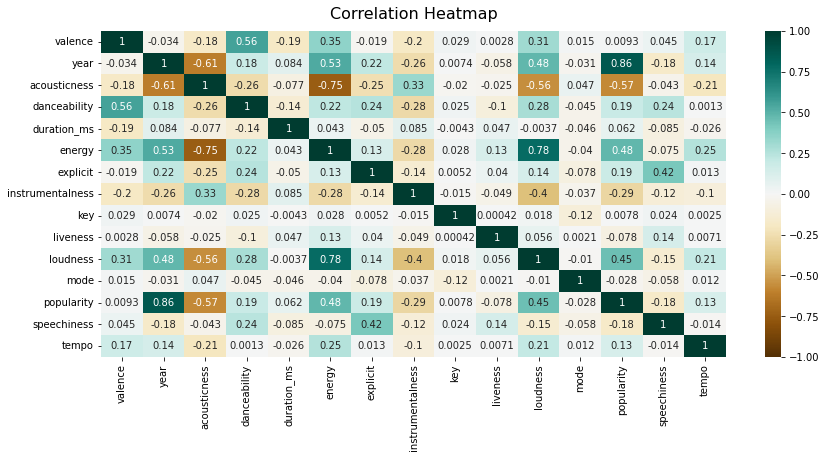

In [15]:
plt.figure(figsize=(14, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 16}, pad=12);

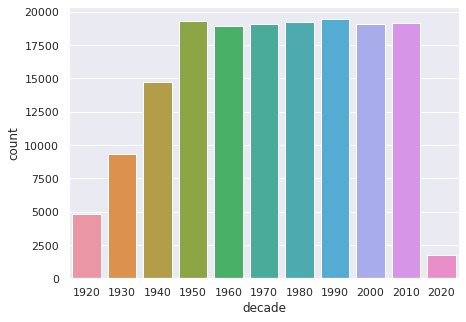

In [16]:
# Visualizing changes in music over decades
def get_decade(year):
    period_start = int(year/10) * 10
    decade = '{}'.format(period_start)
    return decade

df['decade'] = df['year'].apply(get_decade)

sns.set(rc={'figure.figsize':(7, 5)})
sns.countplot(df['decade'].sort_values());

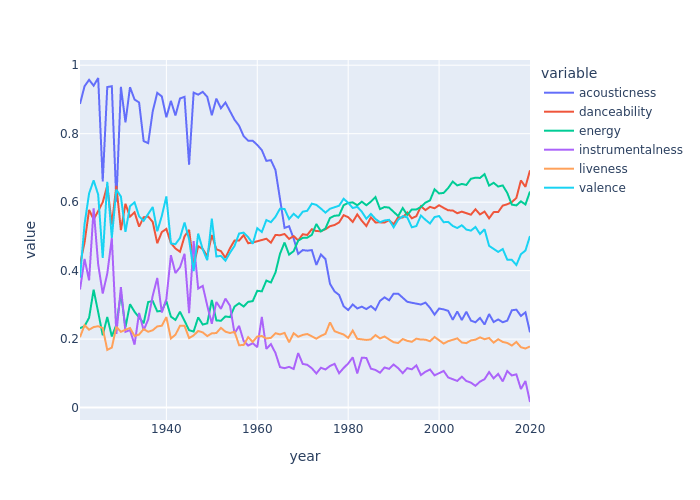

In [28]:
sound_features = ['acousticness', 'danceability', 'energy',
                  'instrumentalness', 'liveness', 'valence']
fig = px.line(df_y, x='year', y=sound_features)
fig.show('png')

From the above visualizations it can be observed that most of the songs are from 1950s-2010s. The features 'popularity' and 'year' have the highest correlation. And the sound features like 'acousticness' and 'instrumentalness' have been drastically changed over decades.

#### Content-Based Recommender

For the content-based recommender, the features `artists` and `genres` will be used. Due to the large dataset, it should be filtered. To get the same amount of data per `decade`, a small portion for each decade with the highest `popularity` ratings will be selected.

In [18]:
def get_dataframe(df, point=0.17):
    decades = list(df['decade'].unique())
    final_df = pd.DataFrame(columns=df.columns)
    for decade in decades:
        data = df.iloc[np.where(df['decade'] == decade)].sort_values(by=['popularity'],
                                                                     ascending=False)
        idx = int(len(data) * point)
        final_df = final_df.append(data[:idx])
    return final_df

In [19]:
df_s = get_dataframe(df)
df_s.shape

(28010, 21)

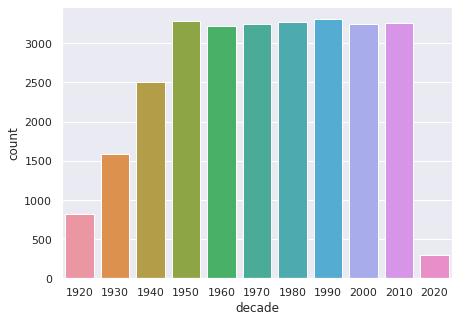

In [20]:
sns.set(rc={'figure.figsize':(7, 5)})
sns.countplot(df_s['decade'].sort_values());

In [21]:
df_s['artists'] = df_s['artists'].str.replace("'", "").apply(
    lambda x: x.strip("[").strip("]"))
df_s['genres'] = df_s['genres'].str.replace("'", "").apply(
    lambda x: x.strip("[").strip("]"))
df_s['music'] = df_s[['artists', 'genres', 'decade']].apply(
    lambda x: ', '.join(x), axis=1)

In [22]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df_s['music'])
tfidf_matrix.shape

(28010, 36324)

In [23]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(28010, 28010)

In [24]:
df_s = df_s.reset_index()
titles = df_s[['name', 'artists', 'genres', 'popularity', 'year']]
indices = pd.Series(df_s.index, index=df_s['name'])

In [25]:
def get_genre_artist(df, name: str):
    genre = df['genres'].iloc[np.where(df['name'] == f'{name}')]
    popularity = df['popularity'].iloc[np.where(df['name'] == f'{name}')]
    print('Song Genre:', list(genre))
    print('Popularity:', popularity.item())
    return genre, popularity


def get_recommendations(name: str, cosine_sim):
    idx = indices[name]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:10]
    song_indices = [i[0] for i in sim_scores]
    return titles.iloc[song_indices].sort_values(['popularity'], ascending=False)

In [26]:
get_genre_artist(df_s, "I Forgot to Remember to Forget")
get_recommendations("I Forgot to Remember to Forget", cosine_sim)

Song Genre: ['rockabilly, rock-and-roll']
Popularity: 30


,name,artists,genres,popularity,year
12239,Jailhouse Rock,Elvis Presley,"rockabilly, rock-and-roll",73,1958
12246,Hound Dog,Elvis Presley,"rockabilly, rock-and-roll",69,1958
12255,Here Comes Santa Claus (Right Down Santa Claus...,Elvis Presley,"rockabilly, rock-and-roll",67,1957
12277,Blue Suede Shoes,Elvis Presley,"rockabilly, rock-and-roll",62,1956
12284,O Little Town of Bethlehem,Elvis Presley,"rockabilly, rock-and-roll",62,1957
12293,Don't Be Cruel,Elvis Presley,"rockabilly, rock-and-roll",61,1958
12295,All Shook Up,Elvis Presley,"rockabilly, rock-and-roll",61,1958
12299,Heartbreak Hotel,Elvis Presley,"rockabilly, rock-and-roll",61,1958
12323,Love Me Tender - From the 20th Century-Fox Cin...,Elvis Presley,"rockabilly, rock-and-roll",58,1958


In [27]:
get_genre_artist(df_s, "GO!!!")
get_recommendations("GO!!!", cosine_sim)

Song Genre: ['latin, reggaeton, reggaeton flow, trap latino, tropical, latin hip hop']
Popularity: 64


,name,artists,genres,popularity,year
6850,Rude,MAGIC!,"latin, reggaeton, reggaeton flow, trap latino,...",79,2014
20885,Sensacion Del Bloque,De La Ghetto,"latin, reggaeton, reggaeton flow, trap latino,...",69,2006
20894,Pasarela,Ñejo & Dalmata,"latin, reggaeton, reggaeton flow, trap latino,...",69,2007
21410,5 Letras,Alexis y Fido,"latin, reggaeton, reggaeton flow, trap latino,...",66,2007
21667,Agárrala - Remix,Trebol Clan,"latin, reggaeton, reggaeton flow, trap latino,...",64,2004
22265,Bien Loco,Nova y Jory,"latin, reggaeton, reggaeton flow, trap latino,...",62,2009
22474,COLORS,FLOW,"latin, reggaeton, reggaeton flow, trap latino,...",61,2003
22456,Tu Te Imaginas,De La Ghetto,"latin, reggaeton, reggaeton flow, trap latino,...",61,2008
23315,Mi Fanatica,De La Ghetto,"latin, reggaeton, reggaeton flow, trap latino,...",59,2006


The system gives the song recommendations based on artists and genres, sorting by popularity.